In [14]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, classification_report, roc_auc_score
import glob
import os
import seaborn as sns

## import data

In [4]:
base = "/Users/ivankoh/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/1D/NUS Y3S1/BT4222/Data"
#train_path = max(glob.glob('../data/train/*.csv'), key=os.path.getctime) 
#test_path = max(glob.glob('../data/test/*.csv'), key=os.path.getctime) 
train_path = max(glob.glob(base + '/train/*.csv'), key=os.path.getctime) 
test_path = max(glob.glob(base +'/test/*.csv'), key=os.path.getctime) 
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(train_df.shape)
print(test_df.shape)

X_train, y_train = train_df.drop('state', axis=1), train_df['state']
X_test, y_test = test_df.drop('state', axis=1), test_df['state']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24756, 579)
(4369, 579)
(24756, 578)
(24756,)
(4369, 578)
(4369,)


## best classifiers 

In [5]:
#SVC 
svc_best = {'kernel': 'linear', 'gamma': 0.1, 'C': 0.001, 'probability':True}
svc_clf = SVC(**svc_best)
svc_clf.fit(X_train, y_train)

#LOGISTIC REGRESSION
lr_clf = LogisticRegression(max_iter=25000, C= 1.601, penalty= 'l2', solver= 'lbfgs')
lr_clf.fit(X_train, y_train)

#RANDOM FOREST
rf_best = {'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 6,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}
rf_clf = RandomForestClassifier(**rf_best)
rf_clf.fit(X_train, y_train)

#XGBOOST 
xgb_clf = XGBClassifier(n_estimators= 150, max_depth = 5, learning_rate = 0.1, subsample = 0.7, colsample_bytree = 0.7)
xgb_clf.fit(X_train, y_train)



/Users/ivankoh/opt/miniconda3/envs/bt4222/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ivankoh/opt/miniconda3/envs/bt4222/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.7, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [6]:
#VOTING
estimators = [('rf', rf_clf), ('xgb', xgb_clf), ('logreg', lr_clf)]
voting_clf = VotingClassifier(estimators=estimators, voting='soft')
voting_clf.fit(X_train, y_train)

#STACKING
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)

/Users/ivankoh/opt/miniconda3/envs/bt4222/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ivankoh/opt/miniconda3/envs/bt4222/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:06:42] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ivankoh/opt/miniconda3/envs/bt4222/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ivankoh/opt/miniconda3/envs/bt4222/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:07:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ivankoh/opt/miniconda3/envs/bt4222/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ivankoh/opt/miniconda3/envs/bt4222/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:08:10] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:08:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:08:25] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=10,
                                                       min_samples_leaf=6,
                                                       min_samples_split=5,
                                                       n_estimators=150)),
                               ('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.7,
                                              enable_categorical=False, gamma=0,
                                              gpu_id=-1, importance_type=None,
                                              interaction_constraints=''...
                                              max_delta_step=0, max_depth=5,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=150, n_jobs=8,
                                              num_parallel_tree=1,
                                              predictor='auto', random_state=0,
                                              reg_alpha=0, reg_lambda=1,
                                              scale_pos_weight=1, subsample=0.7,
                                              tree_method='exact',
                                              validate_parameters=1,
                                              verbosity=None)),
                               ('logreg',
                                LogisticRegression(C=1.601, max_iter=25000))],
                   final_estimator=LogisticRegression())

## NB

In [7]:
X_train_nb = X_train.copy()
X_test_nb = X_test.copy()

train_ohe_cat = X_train_nb.iloc[:, 422:437]
X_train_nb['category'] = train_ohe_cat.idxmax(1)
train_ohe_loc = X_train_nb.iloc[:, 437:-1]
X_train_nb['location'] = train_ohe_loc.idxmax(1)

train_ohe_cat = X_test_nb.iloc[:, 422:437]
X_test_nb['category'] = train_ohe_cat.idxmax(1)
train_ohe_loc = X_test_nb.iloc[:, 437:-1]
X_test_nb['location'] = train_ohe_loc.idxmax(1)

X_train_nb = X_train_nb.drop(X_train_nb.iloc[:, 422:-2].columns, axis=1)
X_test_nb = X_test_nb.drop(X_test_nb.iloc[:, 422:-2].columns, axis=1)

In [8]:
binary_cols = ['staff_pick', 'has_video']
categorical_cols = ['category', 'location']
train_binary = X_train_nb[binary_cols]
train_categorical = X_train_nb[categorical_cols]
test_binary = X_test_nb[binary_cols]
test_categorical = X_test_nb[categorical_cols]

In [9]:
train_numeric = X_train_nb.select_dtypes(include='number').drop(binary_cols, axis=1) 
test_numeric = X_test_nb.select_dtypes(include='number').drop(binary_cols, axis=1) 

In [10]:
# ----- Fit three models -----

model_G = GaussianNB()
clf_G = model_G.fit(train_numeric, y_train)

model_C2 = CategoricalNB()
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)
train_categorical = enc.fit_transform(train_categorical)
test_categorical = enc.transform(test_categorical)
imp = SimpleImputer(strategy="most_frequent") 
train_categorical = imp.fit_transform(train_categorical)
test_categorical = imp.transform(test_categorical)
clf_C2 = model_C2.fit(train_categorical, y_train)

model_B = BernoulliNB()
clf_B = model_B.fit(train_binary, y_train)

# ----- Get probability predictions from each model -----
# On training data
G_train_probas = model_G.predict_proba(train_numeric)
C_train_probas = model_C2.predict_proba(train_categorical)
B_train_probas = model_B.predict_proba(train_binary)

# And on testing data
G_test_probas = model_G.predict_proba(test_numeric)
C_test_probas = model_C2.predict_proba(test_categorical)
B_test_probas = model_B.predict_proba(test_binary)

# Combine probability prediction for class=1 from both models
X_new_train = np.c_[(G_train_probas[:,1], C_train_probas[:,1], B_train_probas[:,1])] # Train
X_new_test = np.c_[(G_test_probas[:,1], C_test_probas[:,1], B_test_probas[:,1])] # Test


# ----- Fit Gaussian model on the X_new -----
model = GaussianNB()
clf = model.fit(X_new_train, y_train)
y_pred = model.predict(X_new_test)

/Users/ivankoh/opt/miniconda3/envs/bt4222/lib/python3.9/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


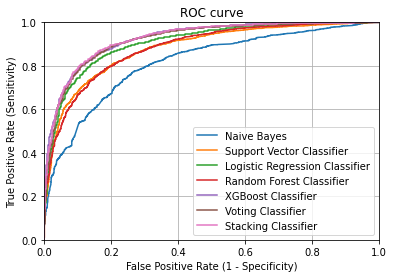

In [11]:
y_pred_prob1 = model.predict_proba(X_new_test)[:, 1]
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred_prob1)
y_pred_prob2 = svc_clf.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, y_pred_prob2)
y_pred_prob3 = lr_clf.predict_proba(X_test)[:, 1]
fpr3, tpr3, thresholds = roc_curve(y_test, y_pred_prob3)
y_pred_prob4 = rf_clf.predict_proba(X_test)[:, 1]
fpr4, tpr4, thresholds = roc_curve(y_test, y_pred_prob4)
y_pred_prob5 = xgb_clf.predict_proba(X_test)[:, 1]
fpr5, tpr5, thresholds = roc_curve(y_test, y_pred_prob5)
y_pred_prob6 = voting_clf.predict_proba(X_test)[:, 1]
fpr6, tpr6, thresholds = roc_curve(y_test, y_pred_prob6)
y_pred_prob7 = stacking_clf.predict_proba(X_test)[:, 1]
fpr7, tpr7, thresholds = roc_curve(y_test, y_pred_prob7)

plt.plot(fpr1, tpr1, label = "Naive Bayes")
plt.plot(fpr2, tpr2, label ="Support Vector Classifier")
plt.plot(fpr3, tpr3, label = "Logistic Regression Classifier")
plt.plot(fpr4, tpr4, label ="Random Forest Classifier")
plt.plot(fpr5, tpr5, label ="XGBoost Classifier")
plt.plot(fpr6, tpr6, label ="Voting Classifier")
plt.plot(fpr7, tpr7, label ="Stacking Classifier")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid(True)

In [12]:
#roc_auc_score based on predict_proba 

print("NB", roc_auc_score(y_test, y_pred_prob1))
print("SVC", roc_auc_score(y_test, y_pred_prob2))
print("LR", roc_auc_score(y_test, y_pred_prob3))
print("RF", roc_auc_score(y_test, y_pred_prob4))
print("XGB", roc_auc_score(y_test, y_pred_prob5))
print("VOTING", roc_auc_score(y_test, y_pred_prob6))
print("STACKING", roc_auc_score(y_test, y_pred_prob7))

NB 0.815975807156679
SVC 0.8815199060829295
LR 0.9068644767170668
RF 0.8826845202087968
XGB 0.9265226780111049
VOTING 0.9213174163506872
STACKING 0.9263303865487954


7
7


/var/folders/dq/33rpc0cx4f54t0vx2cdcgczr0000gn/T/ipykernel_23578/248802355.py:15: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(plot)


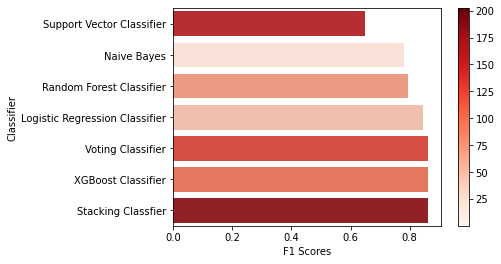

In [33]:
# plot of F1 with hue as efficiency 
names = ["Naive Bayes", "Support Vector Classifier", "Logistic Regression Classifier",
         "Random Forest Classifier", "XGBoost Classifier", "Voting Classifier", "Stacking Classfier"]
f1_scores = [0.7804, 0.6494, 0.8446, 0.7961, 0.8622, 0.8617, 0.8631]
efficiency = [0.006142, 115, 5.152, 14.33, 16.8, 42.05, 202.13]

print(len(f1_scores))
print(len(efficiency))

df = pd.DataFrame({"names": names, "f1_scores": f1_scores, "efficiency": efficiency})
plot_order = df.groupby('names')['f1_scores'].sum().sort_values(ascending=True).index.values

plot = plt.scatter(x=df['names'], y=df["efficiency"], c=df["efficiency"], cmap='Reds')
plt.clf()
plt.colorbar(plot)
ax = sns.barplot(y=df['names'], x=df['f1_scores'], hue=df['efficiency'], palette='Reds', dodge=False, order=plot_order, orient='horizontal')
ax.set_ylabel('Classifier')
ax.set_xlabel('F1 Scores')
ax.legend_.remove()

/var/folders/dq/33rpc0cx4f54t0vx2cdcgczr0000gn/T/ipykernel_23578/2327626116.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(plot)


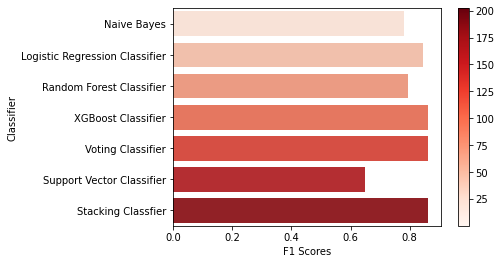

In [34]:
plot_order = df.groupby('names')['efficiency'].sum().sort_values(ascending=True).index.values
plot = plt.scatter(x=df['names'], y=df["efficiency"], c=df["efficiency"], cmap='Reds')
plt.clf()
plt.colorbar(plot)
ax = sns.barplot(y=df['names'], x=df['f1_scores'], hue=df['efficiency'], palette='Reds', dodge=False, order=plot_order, orient='horizontal')
ax.set_ylabel('Classifier')
ax.set_xlabel('F1 Scores')
ax.legend_.remove()